In [1]:
from data.SLP_RD import SLP_RD
from data.SLP_FD import SLP_FD
import argparse
import utils.vis as vis
import utils.utils as ut
import numpy as np
import opt
import cv2
import skimage
import model.A2J as model
import model.anchor as anchor
import math
import torch
from tqdm import tqdm
import json
from os import path

In [2]:
opts = opt.parseArgs()
nm_test = 'sq'   # the suffix for all savings 
# opt.print_options(opts)
model_dir = 'output/ITOP_A2J_exp/model_dump/ITOP_side_30.pth'    # hardwired due in this test case
# feeder
SLP_rd = SLP_RD(opts, phase=opts.test_par)       # test partition 
SLP_fd = SLP_FD(SLP_rd, opts, if_sq_bb=True, df_cut=0.02)

# itop df
joints_name_itop = (
		"Head", "Thorax", "R_Shoulder", "L_Shoulder", "R_Elbow", "L_Elbow", "R_Wrist", "L_Wrist", "Pelvis", "R_Hip",
		"L_Hip", "R_Knee", "L_Knee", "R_Ankle", "L_Ankle")  # max std joints, first joint_num_ori will be true labeled
skels_name_itop = (
		('Pelvis', 'Thorax'),
		('Thorax', 'Head'),
		('Thorax', 'R_Shoulder'), ('R_Shoulder', 'R_Elbow'), ('R_Elbow', 'R_Wrist'),
		('Thorax', 'L_Shoulder'), ('L_Shoulder', 'L_Elbow'), ('L_Elbow', 'L_Wrist'),
		('Pelvis', 'R_Hip'),
		('R_Hip', 'R_Knee'), ('R_Knee', 'R_Ankle'),
		('Pelvis', 'L_Hip'),
		('L_Hip', 'L_Knee'), ('L_Knee', 'L_Ankle'),
	)
skels = ut.nameToIdx(skels_name_itop, joints_name_itop)



test_dataloaders = torch.utils.data.DataLoader(SLP_fd, batch_size=opts.batch_size,
                                               shuffle=False, num_workers=0)
dl_iter = iter(test_dataloaders)
itr_per_epoch = math.ceil(
	SLP_fd.__len__() / opts.num_gpus / opts.batch_size)  # single ds test on batch share
if opts.testIter > 0:
	itr_per_epoch = min(itr_per_epoch, opts.testIter)

initializing SLP: 100%|██████████| 102/102 [00:03<00:00, 25.89it/s]


In [3]:
net = model.A2J_model(num_classes=15)   # 15 is for itop
net.load_state_dict(torch.load(model_dir))
net = net.cuda()
net.eval()
post_precess = anchor.post_process(shape=[288//16,288//16],stride=16,P_h=None, P_w=None)

# save the jts, pth_desc
output = torch.FloatTensor()
bbs = torch.FloatTensor()       # keep all bb directly from the input 
itr_per_epoch = 2       # comment for full test
with torch.no_grad():
    for i in tqdm(range(itr_per_epoch)):        # loop all test
        rst = next(dl_iter)
        img = rst['arr_tch']
        label = rst['jt_tch'] 
        bb = rst['bb_tch'] 
        img, label = img.cuda(), label.cuda()
        heads = net(img)
        pred_keypoints = post_precess(heads, voting=False)  #
        output = torch.cat([output, pred_keypoints.data.cpu()], 0)  # N x n_jt x  3 (x,y:pix, depth:pix?)
        bbs = torch.cat([bbs, bb.data.cpu().float()], 0)  # N x n_jt x  3 (x,y:pix, depth:pix?) float get double  

100%|██████████| 77/77 [01:53<00:00,  1.47s/it]


In [4]:
# check values
# print('img shape', img.size())
result = output.cpu().data.numpy()      # N x n_jt x 3 [ 3: pix] , will be in hm space 
np_bb = bbs.cpu().data.numpy()  # bb in N x 4 
preds_hm, preds_ori = SLP_fd.A2J_postProc(result, np_bb)    #  [x,y:pix, z:m] in ori
preds_cam = ut.pixel2cam(preds_ori, SLP_rd.f_d, SLP_rd.c_d)       # (x, y, depth) from depth map loop the x, y
n_test = len(preds_hm)

In [7]:
## save preds and desc
sv_preds={}
print('get result shape', preds_hm.shape)
sv_preds['pth_desc'] = SLP_rd.pthDesc_li[:n_test]
sv_preds['preds_hm'] = preds_hm.tolist()
sv_preds['preds_ori'] = preds_ori.tolist()  # list format
sv_preds['preds_cam'] = preds_cam.tolist()  # list format
sv_preds['joints_name'] = joints_name_itop      
ut.make_folder(opts.rst_dir)    
svPth = path.join(opts.rst_dir, 'SLP_{}_3d_{}.json'.format(opts.test_par, nm_test))
print('save result in {}'.format(svPth))

with open(svPth,'w') as f:
	json.dump(sv_preds, f, allow_nan = True)

# read in to test
with open(svPth) as f:
	preds_in = json.load(f)

get result shape (4590, 15, 3)
save result in /scratch/liu.shu/codesPool/SLP/output/ITOP_A2J_exp/result/SLP_all_3d.json


In [8]:
n_test=5    #for debug  
sv_dir = opts.vis_test_dir
print('SLP df_cut is', SLP_fd.df_cut)
for idx_show in tqdm(range(n_test)):       # for single test, change here
# 	idx_show = 30
#     jts_cam, jts_ori = SLP_rd.bb2cam(result)
    jt_hm = preds_hm[idx_show]
    jt_ori = preds_ori[idx_show]
    jt_cam = preds_cam[idx_show]
    dpR, jt, bb = SLP_rd.get_array_joints(idx_show, mod='depthRaw')
    RGB, jt_R, bb_R = SLP_rd.get_array_joints(idx_show, mod='RGB')
    RGB = RGB[:,:,::-1]
    jt_R[:,2] =1    #RGB 
    jt_ori[:,2] = 1 # pred_D 
    jt_hm[:,2]=1
    dpR_norm = ut.normImg(dpR)
    # get patch
    # pch, jt_pch = SLP_fd.SLP_A2J(idx_show)
    # jt_pch[:,2] = 1 - jt_pch[:,2]
    # pch = pch.transpose([1,2,0])    # to cv2 format
# pch_nm = ut.normImg(pch.astype(float))

    if False:   # to save ? or show  
        vis.save_2d_tg3d(dpR_norm, jt_ori, skels, sv_dir, idx_show, suffix='_dpR')       # ITOP skels
        vis.save_2d_tg3d(RGB, jt_R, SLP_rd.skels_idx, sv_dir, idx_show, suffix='_RGB-gt')       # ITOP skels
        vis.save_3d_tg3d(jt_cam, sv_dir, skels, idx=idx_show, suffix='A2J')
    else:
        # get pch 
        rst = SLP_fd.SLP_A2J(idx_show)
        pch, jt = rst['arr_tch'], rst['jt_tch']
        print(pch.shape) 
        pch_2d = pch.cpu().numpy()   #  tensor here
        pch_2d = pch_2d.transpose([1,2,0])    # to cv2 format
        pch_2d = np.concatenate((pch_2d,)*3, axis=-1)
        pch_2d_nm = ut.normImg(pch_2d)
        vis_pch = vis.vis_keypoints(pch_2d_nm, jt_hm,  SLP_rd.skels_idx)
        vis_ori = vis.vis_keypoints(dpR_norm, jt_ori, skels) #depthR,
        vis_RGB = vis.vis_keypoints(RGB, jt_R, SLP_rd.skels_idx) # RGB
        # show vis
        vis_jtNum = vis.showJoints(dpR_norm, jt_ori)
        vis.ipyth_imshow(vis_ori)
        vis.ipyth_imshow(vis_RGB)
        vis.ipyth_imshow(vis_pch)
        vis.ipyth_imshow(vis_jtNum)

100%|██████████| 4590/4590 [26:06<00:00,  2.93it/s]  


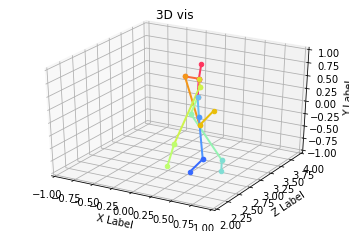

In [16]:
# for 3d vis
rg = [[-1,1], [-1,1], [2,4]]
vis.vis_3d(jt_cam,skel=skels, rg=rg)

